C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [18:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Najlepsze parametry XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Najlepsza CV Accuracy XGBoost: 0.5251071747815459
Validation Accuracy (XGBoost): 0.5306122448979592
Confusion Matrix:
[[192  13 124]
 [ 82   6 126]
 [ 74  18 296]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       329
           1       0.16      0.03      0.05       214
           2       0.54      0.76      0.63       388

    accuracy                           0.53       931
   macro avg       0.42      0.46      0.42       931
weighted avg       0.46      0.53      0.48       931



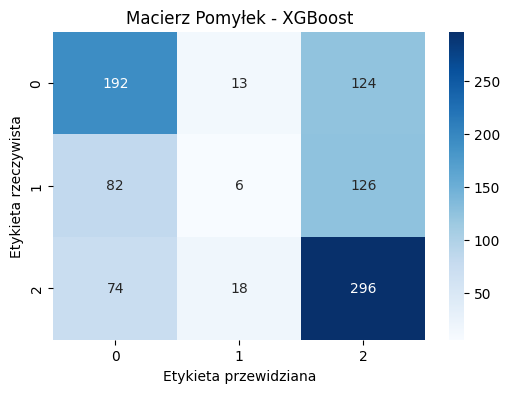

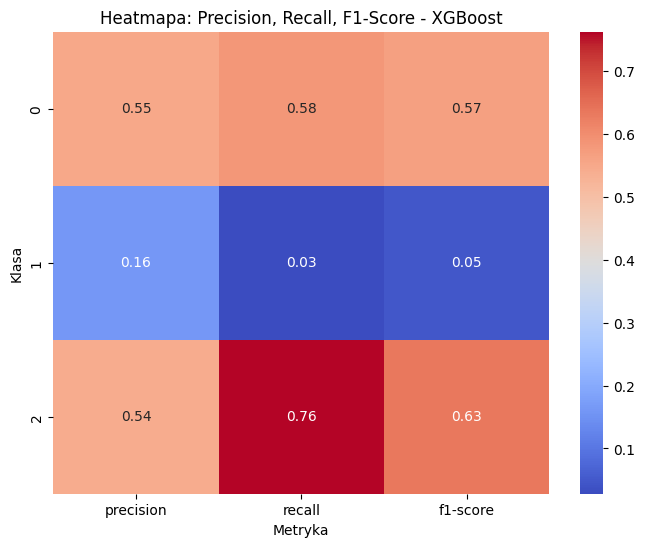

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wczytanie danych
train = pd.read_csv('Train.csv', parse_dates=['Date'])
val = pd.read_csv('Validation.csv', parse_dates=['Date'])

# 2. Przygotowanie cech i etykiety
# Używamy tylko danych dostępnych przed rozpoczęciem meczu:
# - Kursy bukmacherskie: B365H, B365D, B365A, BWH, BWD, BWA
# - Forma drużyn: HomeTeam_Form, AwayTeam_Form
# - Head-to-head: H2H_net
# - Ranking ELO: Home_ELO, Away_ELO
features = [
    'B365H', 'B365D', 'B365A', 
    'BWH', 'BWD', 'BWA',
    'HomeTeam_Form', 'AwayTeam_Form',
    'H2H_net',
    'Home_ELO', 'Away_ELO'
]

X_train = train[features]
y_train = train['FTR_encoded']

X_val = val[features]
y_val = val['FTR_encoded']

# 3. Optymalizacja hiperparametrów dla XGBoost przy użyciu GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Tworzymy obiekt klasyfikatora XGBoost.
# Używamy use_label_encoder=False oraz eval_metric='mlogloss', aby uniknąć ostrzeżeń.
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Najlepsze parametry XGBoost:", grid.best_params_)
print("Najlepsza CV Accuracy XGBoost:", grid.best_score_)

# 4. Trening i predykcja na zbiorze walidacyjnym
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy (XGBoost):", acc)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_val, y_pred))

# 5. Wizualizacje wyników
# 5.1. Heatmapa macierzy pomyłek
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Macierz Pomyłek - XGBoost")
plt.ylabel("Etykieta rzeczywista")
plt.xlabel("Etykieta przewidziana")
plt.show()

# 5.2. Heatmapa precision, recall i f1-score
report_dict = classification_report(y_val, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Zakładamy, że klasy są oznaczone jako '0', '1', '2' (np. odpowiadające H, D, A)
df_metrics = df_report.loc[['0', '1', '2'], ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 6))
sns.heatmap(df_metrics, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmapa: Precision, Recall, F1-Score - XGBoost")
plt.ylabel("Klasa")
plt.xlabel("Metryka")
plt.show()
